In [ ]:
!pip install nltk gensim pyLDAvis boto3 joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.7 MB/s eta 0:00:00


## 1 - Download the data.

Create objects to interact with AWS resources (S3 and DynamoDB)

In [ ]:
import boto3
import pandas as pd
from google.colab import userdata

#Initialize S3 client
s3_client = boto3.client(
    's3',
    aws_access_key_id=userdata.get("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=userdata.get("AWS_SECRET_ACCESS_KEY"),
    region_name=userdata.get("AWS_REGION")
)

dynamodb = boto3.resource(
    'dynamodb',
    aws_access_key_id=userdata.get("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=userdata.get("AWS_SECRET_ACCESS_KEY"),
    region_name=userdata.get("AWS_REGION")
)

#S3 bucket name and DynamoDB table name
s3_bucket_name = "rcg-news-gdelt-clean"
dynamodb_table_name = "file_inference_tracking"
dynamodb_table = dynamodb.Table(dynamodb_table_name)

Get the summarized news from the B3 bucket, using the tracking information on the DynampoDB table.

In [ ]:
from io import BytesIO
import pandas as pd

#Create a function to download all the data from that bucket that has been marked as summarized in the DynamoDB table
def get_summarized_files():
  filter_expression = '(#proc = :val)'
  expression_attribute_values = {':val': True}
  expression_attribute_names = {'#proc': 'processed'}

  #Query unprocessed files and apply date filters
  response = dynamodb_table.scan(
      FilterExpression=filter_expression,
      ExpressionAttributeValues=expression_attribute_values,
      ExpressionAttributeNames=expression_attribute_names
  )

  #Extract and return the filtered file keys
  items = [item["FileKey"] for item in response.get('Items', [])]

  #Get each file of S3 bucket
  df_list = []
  for file_key in items:
    obj = s3_client.get_object(Bucket=s3_bucket_name, Key=file_key)
    df_list.append(pd.read_parquet(BytesIO(obj['Body'].read())))

  #Concatenate all of them and return
  complete_df = pd.concat(df_list, ignore_index=True)
  return complete_df

In [ ]:
df_news = get_summarized_files()
df_news

,url,title,body,date,body_len,body_summary,already_summarized
0,https://tass.com/world/1801277,Iran’s nuclear program corresponds to IAEA req...,"ISTANBUL, June 8. TASS. Iran is pursuing its n...",2024-06-09 01:15:00,501,Iran is ensuring compliance with various inter...,NaN
1,https://www.msnbc.com/weekends-with-alex-witt/...,IDF: Hamas cynically held hostages in crowded ...,BREAKING: VP Harris issues first statement aft...,2024-06-09 00:00:00,508,VP Harris issues statement after Biden drops o...,NaN
2,https://www.nebraska.tv/news/governor-pillen-d...,Governor Pillen discusses Nebraska's property ...,Now. 67. Sat. 77. Sun. 74. byBrooke Peterson. ...,2024-06-09 00:45:00,512,Governor Pillen visits Nebraska to address pro...,NaN
3,https://www.wcyb.com/news/local/jacobs-creek-j...,Jacobs Creek Job Corps car show in Bristol rai...,Now. 87. Sat. 79. Sun. 85. President Biden dro...,2024-06-09 00:00:00,543,President Biden drops out of the 2024 race for...,NaN
4,https://timesofindia.indiatimes.com/india/2-se...,"‘2 Sena (UBT) MPs contacted CM, said they’ll ...",How many kms should you ideally walk in the mo...,2024-06-08 21:30:00,544,Walk 5 kms in the morning for good health. Sou...,NaN
...,...,...,...,...,...,...,...
475602,https://nuclear-news.net/2024/06/24/2-b1-senat...,Senate Nuclear Fetishists Take Lid Off of Pand...,"It s extremely disappointing that, without any...",2024-06-24 15:15:00,7972,"The Senate passed the ADVANCED Act, changing n...",False
475603,https://uk.news.yahoo.com/biden-takes-fresh-im...,Biden takes fresh immigration moves into debat...,By Ted Hesson and Kristina Cooke. WASHINGTON R...,2024-06-24 11:00:00,7974,Biden aims to appeal to skeptical voters by im...,False
475604,https://www.justsecurity.org/author/al-nahhash...,Guest Author,"Dr. Houssam alNahhas, MD, MPH, serves as the M...",2024-06-24 14:30:00,7985,"Dr. Houssam alNahhas, MD, MPH, is a researcher...",False
475605,https://www.slowfood.com/blog-and-news/smoke-m...,"Smoke, mirrors and money: how big ag hoodwinks...",Biodiversity. Education. Advocacy. topics. Wha...,2024-06-24 13:15:00,7987,Farmers in Europe protested against environmen...,False


## 2 - Preprocess the summaries

Imports

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Create the preprocess function for the summaries

In [ ]:
# Function to preprocess text
def preprocess_text(text, steamming=False, preprocess_library="nltk"):

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[\d]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    #USE NLTK
    if preprocess_library == "nltk":
      # Tokenize the text
      tokens = word_tokenize(text)

      # Remove stopwords
      stop_words_nltk = set(stopwords.words('english'))
      tokens = [word for word in tokens if word not in stop_words_nltk]

      # Apply lemmatization
      lemmatizer = WordNetLemmatizer()
      tokens = [lemmatizer.lemmatize(word) for word in tokens]

    elif preprocess_library == "spacy": ##USE SPACY
        # Process the text with spaCy
        doc = nlp(text)

        # Filter and lemmatize tokens
        tokens = [token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS and not token.is_punct and not token.is_space]
    else:
      #If invalid preprocess library, raise an error
      raise ValueError("Invalid preprocess library, must be -> ['nltk', 'spacy']")

    # Apply stemming if required
    if steamming:
      stemmer = SnowballStemmer("english")
      tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

Apply the preprocess function

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

# Assign the results back to the DataFrame
df_news["preprocessed_summaries"] = df_news["body_summary"].progress_apply(lambda x: preprocess_text(x, steamming=True, preprocess_library="spacy"))

  0%|          | 0/475607 [00:00<?, ?it/s]

Save the preprocessed summaries to a CSV

In [ ]:
df_news.to_csv("news_preprocessed.csv", index=False)

Load from CSV (if applicable)

In [ ]:
import time

time.sleep(60*15)

In [ ]:
df_news = pd.read_csv("news_preprocessed.csv").drop_duplicates().dropna(subset="preprocessed_summaries").reset_index(drop=True)

<ipython-input-9-f76d24423da4>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_news = pd.read_csv("news_preprocessed.csv").drop_duplicates().dropna(subset="preprocessed_summaries").reset_index(drop=True)


In [ ]:
df_news.shape

(475587, 8)

## 3 - Determine the optimal parameters

Imports

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

Set both parameters after the

### 3.1 - Optimal number of groups

Create a function to create a corpus from the inputs. Also, set the initial parameters for "no_above" and "no_below"

In [ ]:
def create_corpus_from_df(df, corpus_column, perc=1.0, seed=42, no_below=100, no_above=0.3):

  #Take a subsample of "perc" percentage of the original data in case is needed
  df_sampled = df.sample(frac=perc, random_state=seed)

  # Tokenize the lemmatized text
  tokenized_text = df_sampled[corpus_column].apply(lambda x: x.split())

  # Create a dictionary from the tokenized words
  dictionary = corpora.Dictionary(tokenized_text)

  # Filter out extremes to limit the number of features (optional, depending on your dataset size)
  dictionary.filter_extremes(no_below=no_below, no_above=no_above)

  # Convert the tokenized documents into a bag-of-words corpus
  corpus = [dictionary.doc2bow(text) for text in tokenized_text]

  #Return the tokenized text, the dictionary and the corpus
  return tokenized_text, dictionary, corpus

init_no_above=0.3
init_no_below=100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We first have to determine the number of groups. For that purpose we will iterate doing LDA models for different number of groups.

As it would take too long to create one model for each number of groups with the whole dataset, we will first take a subsample to perfrorm this step and obtaining the number of groups.

Later, we will train a model with the whole dataset and the obtained **optimal** number of groups.

In [ ]:
#Get tokenized text, dictionary and corpus
tokenized_text, dictionary, corpus = create_corpus_from_df(
    df_news,
    corpus_column = "preprocessed_summaries",
    perc = 0.1, #Use 10% of the data available
    seed = 12345,
    no_below=init_no_above,
    no_above=init_no_above
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

In [ ]:
#Create a function to obtain the coherence values for number of groups between start and limit
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=15, step=1):
    """
    Computes coherence values for different numbers of topics.

    Parameters:
    - dictionary: Gensim dictionary object mapping of word ids to words.
    - corpus: Bag of words representation of the documents.
    - texts: List of preprocessed tokenized texts (documents).
    - start: Minimum number of topics to test.
    - limit: Maximum number of topics to test.
    - step: Increment in the number of topics.

    Returns:
    - model_list: List of trained LDA models.
    - coherence_values: List of coherence scores corresponding to the models.
    """
    coherence_values = []
    model_list = []

    # Iterate over the range of topic numbers
    for num_topics in range(start, limit, step):

        print(f"curr num_topics -> {num_topics}")
        # Train the LDA model with the specified number of topics
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                         random_state=42, chunksize=100, passes=10)
        model_list.append(model)

        # Calculate the coherence score for the current model
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

# Compute coherence values for different number of topics
model_list, coherence_values = compute_coherence_values(dictionary, corpus, tokenized_text, start=2, limit=20, step=1)

# Find the optimal number of topics
optimal_num_topics = coherence_values.index(max(coherence_values)) + 2  # Adjust +2 for the starting index
print(f"Optimal number of topics: {optimal_num_topics}")

curr num_topics -> 2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


curr num_topics -> 3
curr num_topics -> 4
curr num_topics -> 5
curr num_topics -> 6
curr num_topics -> 7
curr num_topics -> 8
curr num_topics -> 9
curr num_topics -> 10
curr num_topics -> 11
curr num_topics -> 12
curr num_topics -> 13
curr num_topics -> 14
curr num_topics -> 15
curr num_topics -> 16
curr num_topics -> 17
curr num_topics -> 18
curr num_topics -> 19
Optimal number of topics: 7


Optimal number of topics -> **7**

In [ ]:
optimal_num_topics = 7

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 3.2 - Create *tok*, *dict* and *corp* for the whole dataset

In [ ]:
#Get tokenized text, dictionary and corpus, now for the whole dataset
tokenized_text, dictionary, corpus = create_corpus_from_df(
    df_news,
    corpus_column = "preprocessed_summaries",
    perc = 1.0, #Use the whole dataset
    seed = 12345,
    no_below=init_no_above,
    no_above=init_no_above
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

### 3.3 - Optimal "no_above" and "no_below"

In [ ]:
import matplotlib.pyplot as plt

# Get word frequencies
word_freq = dictionary.dfs  # `dfs` gives document frequencies (number of documents each word appears in)

# Convert to a sorted list of (word, frequency) tuples
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
words, frequencies = zip(*sorted_word_freq)

# Plot the word frequency distribution
plt.figure(figsize=(10, 6))
plt.plot(frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Distribution')
plt.show()

Determine optimal values for parameters.

In [ ]:
optimal_no_above = 0.4
optimal_no_below = 50

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tokenize again with the optimal parameters.

In [ ]:
#Get tokenized text, dictionary and corpus, now for the whole dataset
tokenized_text, dictionary, corpus = create_corpus_from_df(
    df_news,
    corpus_column = "preprocessed_summaries",
    perc = 1.0, #Use the whole dataset
    seed = 12345,
    no_below=optimal_no_above,
    no_above=optimal_no_above
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4 - Train the model

Now, train the model in the whole dataset with the obtained optimal topic number.

In [ ]:
import multiprocessing

lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_num_topics,
    random_state=42,
    chunksize=100,
    passes=20,
    workers=multiprocessing.cpu_count()  # Number of CPU cores to use
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And display the topics with their most frecuent words.

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.010*"event" + 0.009*"communiti" + 0.009*"school" + 0.008*"student" + 0.008*"new" + 0.008*"includ" + 0.008*"like" + 0.006*"support" + 0.006*"offer" + 0.005*"featur"


Topic: 1 
Words: 0.011*"israel" + 0.010*"ukrain" + 0.010*"militari" + 0.009*"war" + 0.009*"gaza" + 0.009*"russia" + 0.009*"support" + 0.008*"china" + 0.007*"conflict" + 0.007*"attack"


Topic: 2 
Words: 0.017*"biden" + 0.014*"presid" + 0.014*"elect" + 0.012*"trump" + 0.012*"parti" + 0.012*"critic" + 0.009*"govern" + 0.009*"state" + 0.009*"support" + 0.009*"democrat"


Topic: 3 
Words: 0.017*"polic" + 0.015*"charg" + 0.012*"arrest" + 0.011*"case" + 0.011*"man" + 0.011*"investig" + 0.010*"court" + 0.010*"face" + 0.009*"alleg" + 0.009*"incid"


Topic: 4 
Words: 0.012*"aim" + 0.011*"compani" + 0.008*"increas" + 0.007*"new" + 0.007*"fund" + 0.007*"develop" + 0.006*"plan" + 0.006*"like" + 0.006*"project" + 0.006*"includ"


Topic: 5 
Words: 0.009*"incid" + 0.009*"hospit" + 0.007*"korea" + 0.006*"health" + 0.006

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get the most frequent words for each topic.

In [ ]:
# Function to extract top words for labeling
def get_topic_labels(lda_model, num_words=5):
    """
    Extracts top words for each topic to create human-readable labels.

    Parameters:
    - lda_model: Trained LDA model.
    - num_words: Number of top words to extract for each topic.

    Returns:
    - topic_labels: Dictionary of topic IDs and their corresponding labels.
    """
    topic_labels = {}

    # Iterate over all topics generated by the model
    for idx, topic in lda_model.show_topics(formatted=False, num_words=num_words):
        # Extract the top words for the topic
        topic_words = [word for word, _ in topic]
        # Join the words into a single label string
        topic_labels[idx] = ' '.join(topic_words)

    return topic_labels

# Get topic labels
topic_labels = get_topic_labels(lda_model, num_words=8)

# Display topic labels
for topic_id, label in topic_labels.items():
    print(f"Topic {topic_id + 1}: {label}")

Topic 1: event communiti school student new includ like support
Topic 2: israel ukrain militari war gaza russia support china
Topic 3: biden presid elect trump parti critic govern state
Topic 4: polic charg arrest case man investig court face
Topic 5: aim compani increas new fund develop plan like
Topic 6: incid hospit korea health medic safeti oper crash
Topic 7: citi water fire resid new expect area caus


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Print the clusters on a PCA.

In [ ]:
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 5 - Wordclouds

Define a function to show the wordcloud (with stopwords removed)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

#Create a word_clow function
def word_cloud(topic, model):
    plt.figure(figsize = (8,6))
    topic_words = [model.print_topic(topic, 75)]
    cloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',
                      width=2500, height=1800).generate(" ".join(topic_words))

    print('\nWordcloud for topic:', topic, '\n')
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And show it for each topic.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Wordcloud for topic: 0 



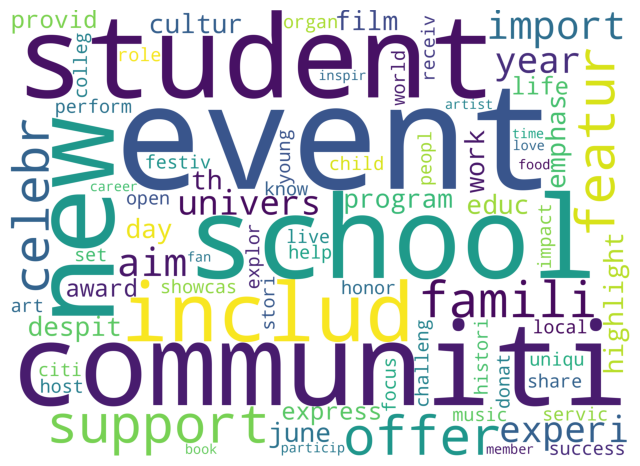


Wordcloud for topic: 1 



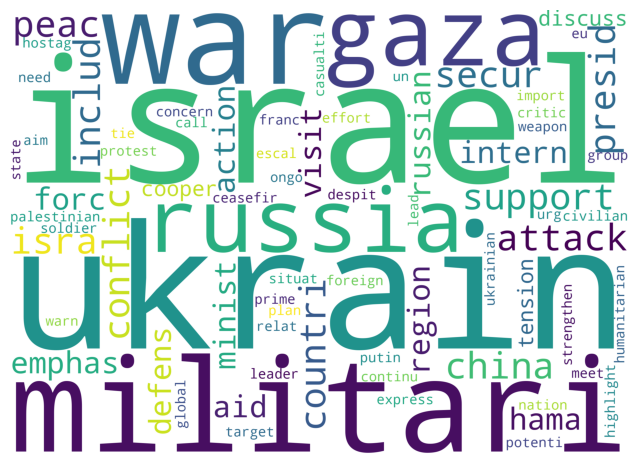


Wordcloud for topic: 2 



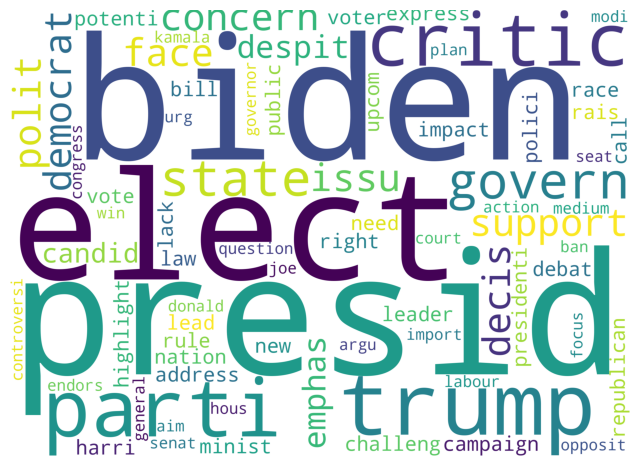


Wordcloud for topic: 3 



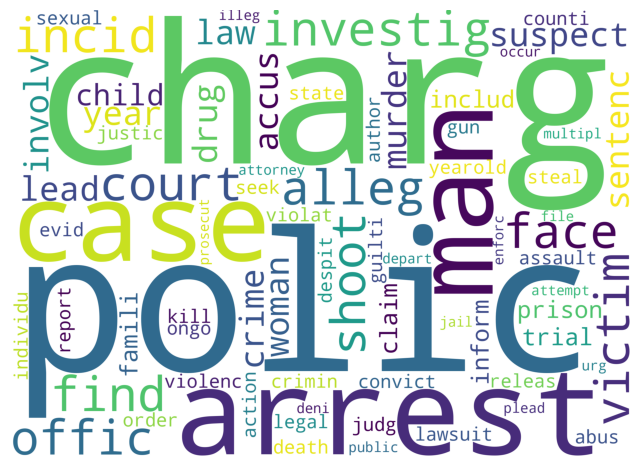


Wordcloud for topic: 4 



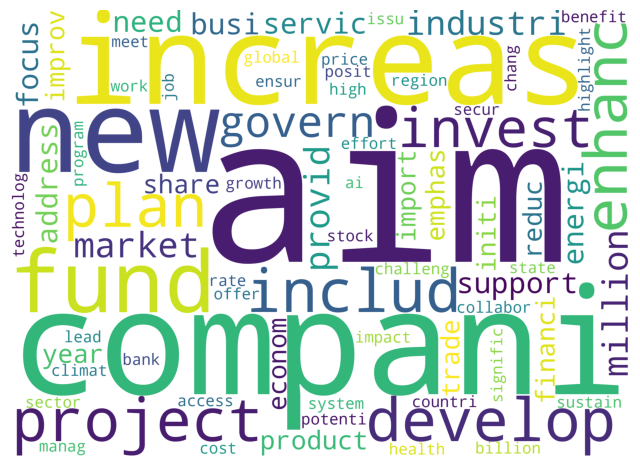


Wordcloud for topic: 5 



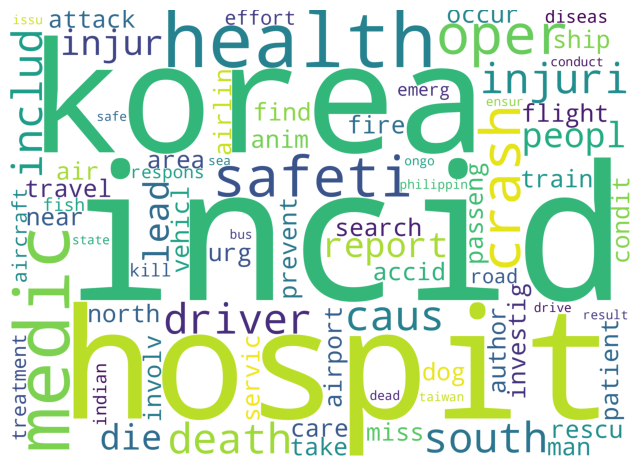


Wordcloud for topic: 6 



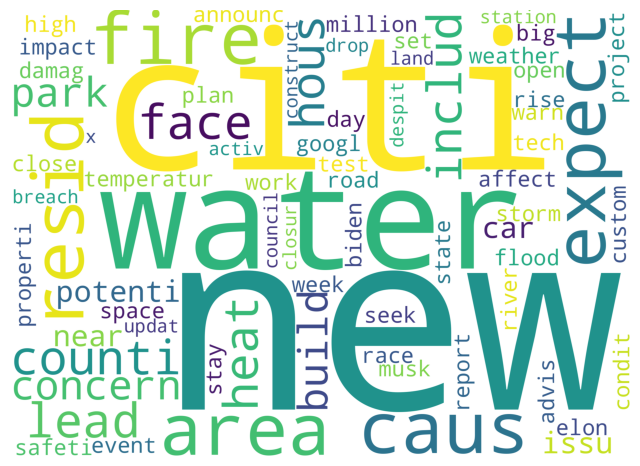

In [ ]:
for topic in range(optimal_num_topics):
    #plt.figure(figsize=(10,15))
    word_cloud(topic, lda_model)

## 6 - Define the topics

Using the wordclouds obtained before, we can infer the following topics:

In [ ]:
topics_dict = {
    0: "Education",
    1: "Conflict",
    2: "Politics",
    3: "Justice",
    4: "Economy",
    5: "Incidents",
    6: "Global"
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 7 - Save the model.

In [ ]:
import re
import string
import json
import pickle
import multiprocessing
from gensim import corpora
from gensim.models import LdaMulticore
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Download NLTK resources if needed
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
class LDAModelWrapper:
    def __init__(self, lda_model, dictionary, config):
        """
        Initializes the LDAModelWrapper with a trained LDA model, dictionary, and configuration.

        Parameters:
        - lda_model: A trained Gensim LdaMulticore model.
        - dictionary: A Gensim Dictionary object used for the model.
        - config: Configuration dictionary or JSON loaded parameters.
        """
        self.lda_model = lda_model
        self.dictionary = dictionary
        self.config = config
        self.stemming = config.get('stemming', False)
        self.preprocess_library = config.get('preprocess_library', 'nltk')
        self.no_above = config.get('no_above', 0.5)
        self.no_below = config.get('no_below', 5)
        self.topics_dict = config.get('topics_dict', {})  # Load the topic labels dictionary from config


    def preprocess_text(self, text):
        """
        Preprocesses the input text based on configuration settings.

        Parameters:
        - text: A string representing the text to preprocess.

        Returns:
        - A list of processed tokens.
        """
        # Convert text to lowercase
        text = text.lower()

        # Remove punctuation and numbers
        text = re.sub(r'[\d]', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))

        if self.preprocess_library == "nltk":
            # Tokenize the text
            tokens = word_tokenize(text)

            # Remove stopwords using NLTK
            stop_words_nltk = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stop_words_nltk]

            # Apply lemmatization
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(word) for word in tokens]

        elif self.preprocess_library == "spacy":
            # Process the text with spaCy
            doc = nlp(text)

            # Filter and lemmatize tokens
            tokens = [token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS and not token.is_punct and not token.is_space]
        else:
            # If invalid preprocess library, raise an error
            raise ValueError("Invalid preprocess library, must be -> ['nltk', 'spacy']")

        # Apply stemming if required
        if self.stemming:
            stemmer = SnowballStemmer("english")
            tokens = [stemmer.stem(word) for word in tokens]

        return tokens

    def get_topic_scores(self, text, threshold=0.1, verbose=False):
        """
        Gets the topic distribution and scores for an unseen document.

        Parameters:
        - text: The unseen document as a string.
        - threshold: Minimum score threshold to display topics.

        Returns:
        - A list of tuples containing topic indices and their scores.
        """
        # Preprocess the unseen document
        tokens = self.preprocess_text(text)
        bow_vector = self.dictionary.doc2bow(tokens)

        # Get topic distribution for the document
        topic_scores = sorted(self.lda_model[bow_vector], key=lambda tup: -tup[1])

        # Filter topics based on the threshold and map to human-readable labels
        filtered_topics = [(self.topics_dict.get(index, f"Topic {index}"), score)
                           for index, score in topic_scores if score >= threshold]

        # Print the topics and scores IF verbose flag added
        if verbose:
          for label, score in filtered_topics:
              print(f"Score: {score}\nTopic: {label}\n")

        return filtered_topics

    def save_model(self, filepath):
        """
        Saves the LDA model and dictionary to a file.

        Parameters:
        - filepath: The path to save the model file.
        """
        with open(filepath, 'wb') as file:
            pickle.dump({'lda_model': self.lda_model, 'dictionary': self.dictionary, 'config': self.config}, file)
        print(f"Model saved to {filepath}")

    @classmethod
    def load_model(cls, filepath):
        """
        Loads the LDA model and dictionary from a file.

        Parameters:
        - filepath: The path to the model file to load.

        Returns:
        - An instance of LDAModelWrapper.
        """
        with open(filepath, 'rb') as file:
            data = pickle.load(file)
        print(f"Model loaded from {filepath}")
        return cls(data['lda_model'], data['dictionary'], data['config'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Encapsulate the parameters of the model in a dict.

In [ ]:
model_config = {
    "stemming": True,
    "preprocess_library": "spacy",
    "no_above": optimal_no_above,
    "no_below": optimal_no_below,
    "topics_dict": topics_dict
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Instantiate the model using the trained lda_model.

In [ ]:
#Instantiate the LDAModelWrapper with the loaded config
lda_wrapper = LDAModelWrapper(lda_model, dictionary, model_config)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test it using a sampled text.

In [ ]:
lda_wrapper.get_topic_scores(
    "This is an example text, let's say I want to talk about how in the university I go there are a lot of good teachers and projects to do, there is even a research part inside that university where students can apply for investigating with the teachers after the lectures.",
    verbose=True
)

Score: 0.666868269443512
Topic: Education

Score: 0.1580822616815567
Topic: Economy

Score: 0.14488859474658966
Topic: Justice



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('Education', 0.66686827), ('Economy', 0.15808226), ('Justice', 0.1448886)]

And save the model.

In [ ]:
lda_wrapper.save_model("lda_model.pkl")

Model saved to lda_model.pkl


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 8 - Test the model on unseen data

In [ ]:
import boto3
import pandas as pd
from io import BytesIO
from google.colab import userdata

# Initialize S3 client
s3 = boto3.client(
    's3',
    aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY'),
    region_name=userdata.get('AWS_REGION')
)

# Bucket name
bucket_name = 'rcg-news-gdelt-tagged'

# List all objects in the bucket
response = s3.list_objects_v2(Bucket=bucket_name)

# Initialize an empty list to store dataframes
dataframes = []

# Iterate over the objects
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('.parquet'):
        # Get the object from S3
        obj = s3.get_object(Bucket=bucket_name, Key=key)

        # Read the parquet file into a pandas DataFrame
        df = pd.read_parquet(BytesIO(obj['Body'].read()))

        # Append the DataFrame to the list
        dataframes.append(df)

# Concatenate all DataFrames into one
if dataframes:
    try:
      unseen_summaries_df = pd.concat(dataframes, ignore_index=True)
    except:
      unseen_summaries_df = pd.concat([d.transpose() for d in dataframes], axis=1, ignore_index=True).T
else:
    unseen_summaries_df = pd.DataFrame()

# Display the first few rows of the concatenated DataFrame
unseen_summaries_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,url,title,body,date,body_summary
0,https://www.thv11.com/article/news/nation-worl...,South Africa opens case at UN court over Israe...,Next up in5. Example video title will go here ...,2024-01-01 00:45:00,South Africa accuses Israel of genocide agains...
1,https://www.kshb.com/news/local-news/kc-realto...,"KC realtor, residents share mixed feelings on ...","Menu. KANSAS CITY, Mo. Conversations continue ...",2024-01-01 03:30:00,Highland Park Village Partners plan to revital...
2,https://en.mercopress.com/2023/12/31/1982-sout...,1982 South Atlantic War: Crippa launches fundr...,"MercoPress,en Espa ol. Get our news on your in...",2024-01-01 01:45:00,Argentine Navy pilot Owen Crippa launched a fu...
3,https://www.fijivillage.com/news/18-year-old-m...,18 year old man charged with trespass and aggr...,An 18yearold man has been charged with one cou...,2024-01-01 03:45:00,An 18-year-old man is charged with trespass an...
4,https://www.thenews.com.pk/print/1143731-more-...,"More than 4,360 dead in Syria war in 2023: mon...","BEIRUT: More than 4,360 people, including comb...",2024-01-01 01:15:00,"Over 4,360 people, including civilians and com..."


And test it (on a subsample).

In [ ]:
unseen_subsample = unseen_summaries_df.sample(frac=0.1)
unseen_subsample.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1800, 5)

In [ ]:
#Create a function that takes a text and get the topic from the model, with the corresponding score
def add_topic_and_score(row):

  #Get the model value for the "body_summary" column
  topic_score = lda_wrapper.get_topic_scores(row["body_summary"])
  #Return both values in a series
  return pd.Series([
      topic_score[0][0], #Topic name for main topic of the summary
      topic_score[0][1]  #Topic score for main topic of the summary
  ])

#Apply to the df
unseen_subsample[["topic_name","topic_score"]] = unseen_subsample.apply(add_topic_and_score, axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
unseen_subsample[["body_summary","topic_name","topic_score"]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,body_summary,topic_name,topic_score
15658,"Zoomlion's Executive Chairman, Dr. Joseph Siaw...",Economy,0.527355
8128,Prime Minister Narendra Modi conducted a roads...,Politics,0.576097
14553,A child dies in a fire at his home in Westmore...,Justice,0.548826
16363,Minister of Transportation Eamon Ryan plans to...,Economy,0.565616
1035,"Three males, approximately 50 years old, were ...",Incidents,0.767698
...,...,...,...
14336,"Workers in Jigawa, Imo, and Osun states protes...",Economy,0.636084
13643,Prime Minister Narendra Modi inaugurates Supre...,Economy,0.449769
4776,"A Brooklyn man, Travis Dickson, receives a pri...",Justice,0.428206
15034,Europe's next outsourcing champion could be Mo...,Economy,0.597386


In [ ]:
unseen_subsample.query("topic_name == 'Economy' & topic_score > 0.8").sample(1).iloc[0].body_summary

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"A deal involving SCB's parent company SCBX is set for completion in the first half of 2025, pending regulatory approvals in Vietnam and Thailand. The Vietnamese consumer lending market has seen recent ownership changes, with companies like Saigon Hanoi Bank and VPBank transferring significant stakes to Thai and Japanese firms. Revenue for financial companies has sharply decreased in 2023, with rising bad debts and low borrower repayment ability leading to tighter lending standards. Experts call for coordinated policies to stabilize the market."